In [35]:
from dataset import OpencpopDataset, MusicLoaderGenerator
from helper import parser_line, merge_note, get_pitch_labels, get_transposed_phoneme_labels, print_all

## 数据集加载

In [36]:
def dataset_transform(sample, sample_rate=None):
    id, text, phoneme, note, note_duration, phoneme_duration, slur_note = parser_line(sample['text'])
    text_with_p, phoneme, note, note_duration, slur_note = merge_note(text, phoneme, note, note_duration, slur_note)
    sample['chinese'] = text_with_p
    sample['phoneme'] = phoneme
    sample['note'] = note
    sample['duration'] = note_duration
    sample['slur'] = slur_note
    return sample

dataset = OpencpopDataset('/scratch/bh2283/data/opencpop/segments/', transform=dataset_transform, sample_rate=22050)

In [37]:
train_set, test_set = dataset.split()
len(train_set), len(test_set)

(3744, 12)

In [38]:
BATCH_SIZE = 4
note_labels = get_pitch_labels()
phoneme_labels = get_transposed_phoneme_labels()
slur_labels = [0, 1]
# 0-1 分辨率0.01，1-2 分辨率0.05，2-7 分辨率0.2
duration_labels = [i for i in range(7)]

labels = (
    phoneme_labels,
    note_labels,
    slur_labels
)
loaderGenerator = MusicLoaderGenerator(labels)
train_loader = loaderGenerator.dataloader(train_set, batch_size=BATCH_SIZE)
test_loader = loaderGenerator.dataloader(test_set, batch_size=1)
print('train_set:', len(train_set), 'test_set:',len(test_set))
steps = 1
for i_batch, sample_batched in enumerate(train_loader):
    if steps <= 0:
        break

    print(sample_batched['chinese'])
    print(sample_batched['phoneme'].shape)
    print(sample_batched['phoneme_pre'].shape)
    print(sample_batched['note_post'].shape)
    print(sample_batched['audio_duration_quant'])
    print(sample_batched['mel'].shape)
    print(sample_batched['mel_len'].shape, sample_batched['mel_len'])
    steps -= 1

train_set: 3744 test_set: 12
['想', '要', '变', '成', '你', '猫', 'AP', '赖', '在', '你', '怀', '睡', '着', 'AP', '假', '~', '装', 'SP', 'AP', '那', '只', '是', 'AP', 'SP', '吹', '远', '鸣', '唱', '的', '诗', '篇', '~', 'AP', '依', '旧', '留', '着', '你', '的', '笑', '容', 'SP', 'AP']
torch.Size([43, 2])
torch.Size([43, 2])
torch.Size([43])
tensor([13, 11,  8, 15,  9, 17,  8, 10, 10, 11, 12, 25, 12,  7, 15, 15, 91, 17,
        14, 24, 11, 34,  8,  7, 13, 20, 17, 21,  8, 18, 21, 52, 14, 12, 29, 15,
        11, 22, 11, 29, 25,  9, 11])
torch.Size([43, 80, 194])
torch.Size([43]) tensor([ 27,  24,  18,  31,  20,  35,  17,  21,  22,  24,  25,  51,  26,  15,
         32,  32, 194,  35,  29,  50,  23,  70,  18,  16,  28,  41,  36,  43,
         18,  38,  43, 105,  29,  25,  60,  32,  23,  46,  24,  60,  51,  20,
         23])


# Model 设计

- 尝试使用逆卷积，上采样得到所需的音频
- 我们无需去计算时间停止符，只需要在输出的时间内计算loss并且最小化即可
- 设定一个最大时间长度，比如两秒，超过的就不要了（用阈值筛掉）
- 多层上采样得到最佳的输出
- 使用梅尔频谱，还有解码器，可以使得输出音质比stft好（猜的，需要验证）一般机器学习声码器都会好点

但是有问题：
- 使用逆卷积太过刚直，没有变化性，导致无法很好的收敛
- 一般逆卷积和GAN一起使用，用判别器取代刚直的loss
- 使用tacotron模式就会好很多，无需GAN，自收敛

In [39]:
from torchaudio.models.tacotron2 import Tacotron2, _get_mask_from_lengths, _Decoder, _Encoder, _Postnet
from torchaudio.pipelines._tts.utils import _get_taco_params
import torch
from torch import Tensor
from typing import Tuple, List, Optional, Union, overload

class TacotronTail(Tacotron2):
    def __init__(
        self,
        labels_lens: dict,
        decoder = None,
        postnet = None,
    ) -> None:
        _tacotron2_params=_get_taco_params(n_symbols=5) # ignore n_symbols, encoder not used 
        super().__init__(**_tacotron2_params)

        embedding_dim = _tacotron2_params['encoder_embedding_dim']
        self.embeddings = {
            key: torch.nn.Embedding(value, embedding_dim)
            for key, value in labels_lens.items()
        }
        self.embedding_register = torch.nn.ModuleList(self.embeddings.values())
        # 将embedding注册进模型，不确定是否复制，需要在实践中测试
        if decoder is not None:
            self.decoder: _Decoder = decoder
        if postnet is not None:
            self.postnet: _Postnet = postnet
        self.reduce_phoneme = lambda x: torch.sum(x, 1) if len(x.shape)==3 else x
        self.decoder.decoder_max_step = int(4 * 22050 / 256)
        self.version = '0.01'

    def forward(
        self,
        inputs: dict,
    ):
        embedded_inputs = [
            self.reduce_phoneme(self.embeddings[key](inputs[key])) for key in self.embeddings.keys()
        ]
        embedded_inputs = torch.stack(embedded_inputs).sum(0).unsqueeze(1) # [bs, 1, emb_size]
        # print('embedded_inputs', embedded_inputs.shape)
        mel_specgram = inputs['mel'] # (n_batch, ``n_mels``, max of ``mel_specgram_lengths``)
        # print('mel_specgram', mel_specgram.shape)
        mel_specgram_lengths = inputs['mel_len']
        mel_specgram, gate_outputs, alignments = self.decoder(
            embedded_inputs, mel_specgram, memory_lengths=torch.ones_like(mel_specgram_lengths),
        )

        mel_specgram_postnet = self.postnet(mel_specgram)
        mel_specgram_postnet = mel_specgram + mel_specgram_postnet

        if self.mask_padding:
            mask = _get_mask_from_lengths(mel_specgram_lengths)
            mask = mask.expand(self.n_mels, mask.size(0), mask.size(1))
            mask = mask.permute(1, 0, 2)

            mel_specgram.masked_fill_(mask, 0.0)
            mel_specgram_postnet.masked_fill_(mask, 0.0)
            gate_outputs.masked_fill_(mask[:, 0, :], 1e3)

        return mel_specgram, mel_specgram_postnet, gate_outputs, alignments

    @torch.jit.export
    def infer(
        self, 
        inputs: dict,
        ) -> Tuple[Tensor, Tensor, Tensor]:

        embedded_inputs = [
            self.reduce_phoneme(self.embeddings[key](inputs[key])) for key in self.embeddings.keys()
        ]
        embedded_inputs = torch.stack(embedded_inputs).sum(0).unsqueeze(1) # [bs, 1, emb_size]
        # print('embedded_inputs', embedded_inputs.shape)
        
        n_batch = embedded_inputs.shape[0]
        mel_specgram, mel_specgram_lengths, _, alignments = \
            self.decoder.infer(embedded_inputs, memory_lengths=torch.ones(n_batch))

        mel_outputs_postnet = self.postnet(mel_specgram)
        mel_outputs_postnet = mel_specgram + mel_outputs_postnet

        alignments = alignments.unfold(1, n_batch, n_batch).transpose(0, 2)

        return mel_outputs_postnet, mel_specgram_lengths, alignments

In [40]:
labels_lens = {
    'audio_duration_quant': 130, # 这个是量化后的计算结果
    'phoneme': len(phoneme_labels), # 拼音
    'phoneme_pre': len(phoneme_labels), # 前一个汉字的拼音
    'phoneme_post': len(phoneme_labels), # 后一个汉字的拼音
    'note': len(note_labels), # 音调音符
    'note_pre': len(note_labels),
    'note_post': len(note_labels),
    'slur': len(slur_labels), # 是否为延长音
}
model = TacotronTail(labels_lens)
steps = 1
for i_batch, sample_batched in enumerate(train_loader):
    if steps <= 0:
        break
    model.infer(sample_batched)
    # print(sample_batched['chinese'])
    # print(sample_batched['phoneme'].shape)
    # print(sample_batched['phoneme_pre'].shape)
    # print(sample_batched['note_post'].shape)
    # print(sample_batched['audio_duration_quant'])
    # print(sample_batched['mel'].shape)
    # print(sample_batched['mel_len'].shape, sample_batched['mel_len'])
    steps -= 1


/scratch/bh2283/penv/lib/python3.10/site-packages/torchaudio/models/tacotron2.py:860: UserWarning: Reached max decoder steps. The generated spectrogram might not cover the whole transcript.
  warnings.warn(


## 训练

- 初始参数配置
- 训练

In [41]:
LOG_DIR = './log/tacotron-1-'
LEARNING_RATE = 0.001
LOAD_PATH = './checkpoint/pre.pt'
def save_log(file_name, log, mode='a', path = LOG_DIR):
    with open(path+file_name, mode) as f:
        if mode == 'a':
            f.write('\n')
        if type(log) is str:
            f.write(log)
            print(log)
        else:
            log = [str(l) for l in log]
            f.write(' '.join(log))
            print(' '.join(log))

In [53]:
from os.path import exists
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def load_checkpoint(path):
    if exists(path):
        save_log(f'e.txt', ['path', path, 'exist, loading...'])
        checkpoint = torch.load(path, map_location=device)
        if 'model_state_dict' in checkpoint:
            model.decoder.load_state_dict(checkpoint['model_state_dict'], strict=False) # , strict=False?
            model.postnet.load_state_dict(checkpoint['model_state_dict'], strict=False)

load_checkpoint(LOAD_PATH)

path ./checkpoint/t2.pt exist, loading...


In [43]:
# checkpoint = torch.load(LOAD_PATH, map_location=device)

In [44]:
# delet_keys = [
#     'postnet.convolutions.4',
#     'postnet.convolutions.0',
#     'decoder.linear_projection',
#     'decoder.prenet.layers.0'
# ]
# def check_delet(q, delet_keys):
#     for key in delet_keys:
#         l = len(key)
#         if q[:l] == key:
#             return True
#     return False
# delet_keys = [q for q in checkpoint['model_state_dict'].keys() if check_delet(q, delet_keys)]
# for key in delet_keys:
#     del checkpoint['model_state_dict'][key]

In [45]:
# model

In [54]:
params = model.parameters()
# params = list(model.embedding.parameters())+list(model.encoder.parameters())+list(model.speaker_encoder.parameters())
# optimizer = torch.optim.SGD(params, lr=LEARNING_RATE, momentum=0.5)
optimizer = torch.optim.Adam(params, lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
initial_epoch = 0
mse_loss = torch.nn.MSELoss()
bce_loss = torch.nn.BCELoss()
cos_loss = torch.nn.CosineEmbeddingLoss()
mean = lambda x: sum(x)/len(x)

In [55]:
def dump_model(EPOCH, LOSS, PATH):
    torch.save({
            'epoch': EPOCH,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': LOSS,
            }, PATH)

def save_temp(EPOCH, LOSS):
    PATH = f"./checkpoint/model_temp.pt"
    dump_model(EPOCH, LOSS, PATH)
    
def save_checkpoint(EPOCH, LOSS):
    PATH = f"./checkpoint/model_{EPOCH}_{'%.3f' % LOSS}.pt"
    dump_model(EPOCH, LOSS, PATH)

In [48]:
# def train(epoch=1):
#     train_loss_q = []
#     test_loss_q = []
#     for epoch in range(initial_epoch, epoch):
#         batch_train_loss = []
#         for i_batch, sample_batched in enumerate(train_loader):
#             model.train()
#             # Step 1. Prepare Data
#             mels_tensor = sample_batched['mel'].to(device) # [bs, mel_bins, L]
#             mel_length = sample_batched['mel_len'].to(device)

#             # Step 2. Run our forward pass

#             org_mel, pos_mel, stop_token, _ = model.forward(sample_batched)
#             loss1 = mse_loss(mels_tensor, org_mel)
#             loss1 += mse_loss(mels_tensor, pos_mel)

#             true_stop_token = torch.zeros(stop_token.shape).to(device)
#             for i in range(true_stop_token.shape[0]):
#                 true_stop_token[i][mel_length[i]:]+=1.0
#             loss2 = bce_loss(torch.sigmoid(stop_token), true_stop_token)
            
#             # Step 3. Run our backward pass
#             optimizer.zero_grad()
#             loss = loss1 + loss2
#             loss.backward()
#             optimizer.step()

#             if loss.item()!=loss.item(): # if loss == NaN, break
#                 print('NaN hit!')
#                 exit()
            
#             batch_train_loss.append(loss.item())

#             if i_batch % (3000 // BATCH_SIZE) == 0: # log about each n data
#                 # test_loss = test()
#                 test_loss = 0
#                 train_loss = mean(batch_train_loss)
#                 test_loss_q.append(test_loss)
#                 train_loss_q.append(train_loss)
#                 save_log(f'e{epoch}.txt', ['🟣 epoch', epoch, 'data', i_batch*BATCH_SIZE, 
#                     'lr', scheduler.get_last_lr(), 
#                     'train_loss', '{:.3f}'.format(train_loss), 
#                     'test_loss', test_loss, 
#                     'bce_loss', '{:.3f}'.format(loss2.item())])
#                 save_temp(epoch, test_loss) # save temp checkpoint
#                 # test_decoder(epoch, 5)
            
#             # exit()
            
#         # scheduler.step()
#         save_checkpoint(epoch, mean(test_loss_q))
#         save_log(f'e{epoch}.txt', ['============= Final Test ============='])
#         # test_decoder(epoch, 10) # run some sample prediction and see the result


In [49]:
# train()

In [56]:
LOAD_PATH = './checkpoint/t2.pt'

def load_checkpoint(path):
    if exists(path):
        save_log(f'e.txt', ['path', path, 'exist, loading...'])
        checkpoint = torch.load(path, map_location=device)
        if 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'], strict=True)
            # model.decoder.load_state_dict(checkpoint['model_state_dict'], strict=False) # , strict=False?
            # model.postnet.load_state_dict(checkpoint['model_state_dict'], strict=False)

load_checkpoint(LOAD_PATH)

path ./checkpoint/t2.pt exist, loading...


In [57]:
test_iter = iter(test_loader)

In [58]:
sample_batched = next(test_iter)
# sample_batched = next(test_iter)
mel_outputs_postnet, mel_specgram_lengths, _ = model.infer(sample_batched)

In [59]:
sample_batched['note']

tensor([24, 24,  5, 35, 36, 21, 21, 24, 30, 24,  7, 14, 36])

In [60]:
import matplotlib
import matplotlib.pyplot as plt
import torchaudio
matplotlib.rcParams["figure.figsize"] = [16.0, 4.8]

In [61]:
waveglow = torch.hub.load(
    "NVIDIA/DeepLearningExamples:torchhub",
    "nvidia_waveglow",
    model_math="fp32",
    pretrained=False,
)
device = "cuda" if torch.cuda.is_available() else "cpu"
checkpoint = torch.hub.load_state_dict_from_url(
    "https://api.ngc.nvidia.com/v2/models/nvidia/waveglowpyt_fp32/versions/1/files/nvidia_waveglowpyt_fp32_20190306.pth",  # noqa: E501
    progress=False,
    map_location=device,
)
state_dict = {key.replace("module.", ""): value for key, value in checkpoint["state_dict"].items()}
waveglow.load_state_dict(state_dict)
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to(device)
waveglow.eval()
''

Using cache found in /home/bh2283/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/home/bh2283/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/home/bh2283/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/home/bh2283/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/SpeechSynthesis/Tacotron2/waveglow/model.py:55: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'co

''

path ./checkpoint/t2.pt exist, loading...


'马'

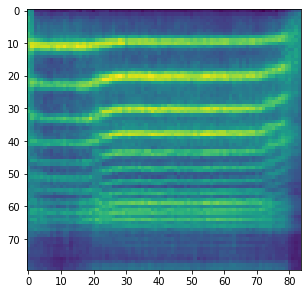

In [62]:
load_checkpoint(LOAD_PATH)
mel_outputs_postnet, mel_specgram_lengths, _ = model.infer(sample_batched)
idx = 3
mel = mel_outputs_postnet[idx]
gen_mel = mel[:, :mel_specgram_lengths[idx]]
plt.imshow(gen_mel.detach().numpy(), interpolation='none')

waveforms = waveglow.infer(gen_mel.unsqueeze(0))
torchaudio.save("waveglow_reconstruct.wav", waveforms[0:1], sample_rate=22050)

sample_batched['chinese'][idx]

'马'

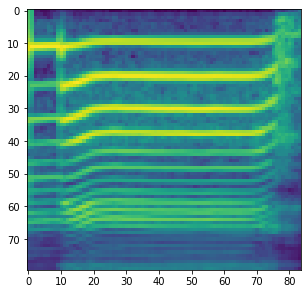

In [63]:
org_mel=sample_batched['mel'][idx][:, :sample_batched['mel_len'][idx]]
plt.imshow(org_mel.detach().numpy(), interpolation='none')

waveforms = waveglow.infer(org_mel.unsqueeze(0))
torchaudio.save("waveglow_org.wav", waveforms[0:1], sample_rate=22050)

sample_batched['chinese'][idx]

生成高亮度部分的mask，之后应用可以使这一部分被看重，增加其权重

In [64]:
gen_mel.shape

torch.Size([80, 84])

In [65]:
gen_mel.var(), gen_mel.mean(), org_mel.var(), org_mel.mean()

(tensor(3.6267, grad_fn=<VarBackward0>),
 tensor(-5.9119, grad_fn=<MeanBackward0>),
 tensor(3.5994),
 tensor(-5.6023))

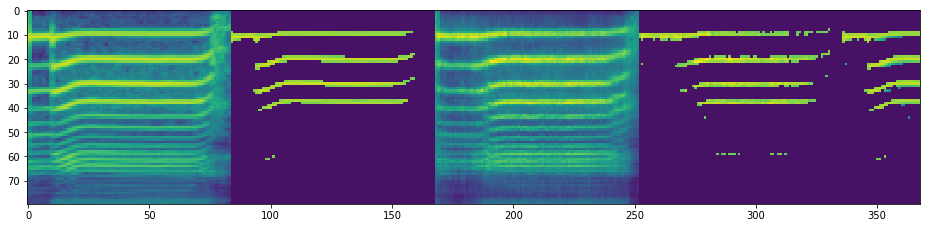

In [66]:
threshold = 0.9
gen_mask = gen_mel < gen_mel.mean() + gen_mel.var()*threshold
gen_masked_mel = gen_mel.masked_fill(gen_mask, -10)
org_mask = org_mel < org_mel.mean() + org_mel.var()*threshold
org_masked_mel = org_mel.masked_fill(org_mask, -10)
# minshape = min(org_mask.shape[-1], gen_mask.shape[-1])
org_masked_mel2 = org_mel[:,:32].masked_fill(org_mask[:,:32].bitwise_and(gen_mask[:,:32]), -10)
# plt.imshow(gen_mel.detach().numpy(), interpolation='none')
plt.imshow(torch.cat([org_mel, org_masked_mel, gen_mel, gen_masked_mel, org_masked_mel2], dim=1).detach().numpy(), interpolation='none')

In [67]:
def threshold_mse_loss(mel1, mel2, threshold=0.2, mask_fill_val=0):
    # threshold should be in [0,1]
    # the larger the threshold, the smaller area selected
    # mel1 [mel_bins, time], mel1 and mel2 should have same time
    assert mel1.shape[1] == mel2.shape[1]
    mask1 = mel1 < mel1.mean() + mel1.var()*threshold
    mask2 = mel2 < mel2.mean() + mel2.var()*threshold
    and_mask = mask1.bitwise_and(mask2)
    return mel1.masked_fill(and_mask, mask_fill_val), mel2.masked_fill(and_mask, mask_fill_val)

In [68]:
plt.imshow(torch.cat(threshold_mse_loss(org_mel, gen_mel[:, :32], 0.2), dim=1).detach().numpy(), interpolation='none')

AssertionError: 

# 自己写一段音频

单个汉字测试

In [69]:
data = {
    'audio_duration_quant': [0.3], # 量化后音屏时间长度
    'chinese': ['王'], # 该音频汉字
    'phoneme': [['w', 'ang']], # 拼音
    'phoneme_pre': [['SP']], # 前一个汉字的拼音
    'phoneme_post': [['ch', 'eng']], # 后一个汉字的拼音
    'note': ['F#4/Gb4'], # 音调音符
    'note_pre': ['rest'],
    'note_post':['F#4/Gb4'],
    'slur': [0],
}
data = loaderGenerator.data_transfer(data)
data

{'audio_duration_quant': tensor([12]),
 'chinese': ['王'],
 'phoneme': tensor([[24, 49]]),
 'phoneme_pre': tensor([[61,  0]]),
 'phoneme_post': tensor([[17, 52]]),
 'note': tensor([27]),
 'note_pre': tensor([36]),
 'note_post': tensor([27]),
 'slur': tensor([0])}

In [70]:
mel_outputs_postnet, mel_specgram_lengths, _ = model.infer(data)

'王'

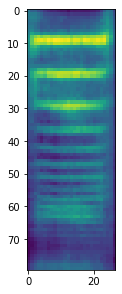

In [71]:
idx = 0
mel = mel_outputs_postnet[idx]
mel = mel[:, :mel_specgram_lengths[idx]]
plt.imshow(mel.detach().numpy(), interpolation='none')

waveforms = waveglow.infer(mel.unsqueeze(0))
torchaudio.save("waveglow_reconstruct.wav", waveforms[0:1], sample_rate=22050)

data['chinese'][idx]

整句测试

In [72]:
data_org = {
    'audio_duration_quant': [0.18523, 0.17741, 0.19393, 0.25967, 0.29934, 0.21555, 0.03177, 0.19752, 0.16545, 0.18476, 0.21229, 0.24696, 0.44037, 1.52495, 0.85583, 0.5591], # 单字时间长度（秒）
    'chinese': ['漂', '浮', '在', '~', '~', 'AP', 'SP', '一', '~', '片', '~', '~', '无', '奈', 'SP', 'AP'], # 该音频汉字
    'phoneme': [['p', 'iao'], ['f', 'u'], ['z', 'ai'], ['ai', '-'], ['ai', '-'], ['AP', '-'], ['SP', '-'], ['y', 'i'], ['i', '-'], ['p', 'ian'], ['ian', '-'], ['ian', '-'], ['w', 'u'], ['n', 'ai'], ['SP', '-'], ['AP', '-']], # 拼音
    'phoneme_pre': [['AP'], ['p', 'iao'], ['f', 'u'], ['z', 'ai'], ['ai', '-'], ['ai', '-'], ['AP', '-'], ['SP', '-'], ['y', 'i'], ['i', '-'], ['p', 'ian'], ['ian', '-'], ['ian', '-'], ['w', 'u'], ['n', 'ai'], ['SP', '-']], # 前一个汉字的拼音
    'phoneme_post': [['f', 'u'], ['z', 'ai'], ['ai', '-'], ['ai', '-'], ['AP', '-'], ['SP', '-'], ['y', 'i'], ['i', '-'], ['p', 'ian'], ['ian', '-'], ['ian', '-'], ['w', 'u'], ['n', 'ai'], ['SP', '-'], ['AP', '-'], ['AP']], # 后一个汉字的拼音
    'note': ['E4', 'F#4/Gb4', 'G#4/Ab4', 'A4', 'G#4/Ab4', 'rest', 'rest', 'E4', 'F#4/Gb4', 'G#4/Ab4', 'A4', 'G#4/Ab4', 'E4', 'F#4/Gb4', 'rest', 'rest'], # 音调音符
    'note_pre': ['rest', 'E4', 'F#4/Gb4', 'G#4/Ab4', 'A4', 'G#4/Ab4', 'rest', 'rest', 'E4', 'F#4/Gb4', 'G#4/Ab4', 'A4', 'G#4/Ab4', 'E4', 'F#4/Gb4', 'rest'],
    'note_post':['F#4/Gb4', 'G#4/Ab4', 'A4', 'G#4/Ab4', 'rest', 'rest', 'E4', 'F#4/Gb4', 'G#4/Ab4', 'A4', 'G#4/Ab4', 'E4', 'F#4/Gb4', 'rest', 'rest', 'rest'],
    'slur': [0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0],
}
data = loaderGenerator.data_transfer(data_org)
# data

In [73]:
mel_outputs_postnet, mel_specgram_lengths, _ = model.infer(data)

('~', 0.25967)

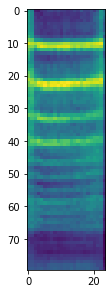

In [74]:
idx = 3
mel = mel_outputs_postnet[idx]
mel = mel[:, :mel_specgram_lengths[idx]]
plt.imshow(mel.detach().numpy(), interpolation='none')

waveforms = waveglow.infer(mel.unsqueeze(0))
torchaudio.save("waveglow_reconstruct.wav", waveforms[0:1], sample_rate=22050)

data['chinese'][idx], data_org['audio_duration_quant'][idx]

In [75]:
waveforms.shape

torch.Size([1, 6144])

In [76]:
def generate_waveform(mel_outputs_postnet, mel_specgram_lengths):
    waveforms = []
    for idx in range(len(data_org['chinese'])):
        mel = mel_outputs_postnet[idx]
        mel = mel[:, :mel_specgram_lengths[idx]]
        waveform = waveglow.infer(mel.unsqueeze(0))[0][:int(22050 * data_org['audio_duration_quant'][idx])]
        waveforms.append(waveform)
    return torch.cat(waveforms).unsqueeze(0)

In [77]:
waveform = generate_waveform(mel_outputs_postnet, mel_specgram_lengths)
torchaudio.save("waveglow_reconstruct.wav", waveform, sample_rate=22050)

修改歌词试试

In [78]:
from pypinyin import lazy_pinyin, Style
def chinese2pinyin(text):
    # 单个汉字转换
    initials = lazy_pinyin(text, strict=False, style=Style.INITIALS, errors=lambda x: u'')
    finals = lazy_pinyin(text, strict=False, style=Style.FINALS, errors=lambda x: u'')
    pinyin = [initials[0], finals[0]] if len(initials[0])!=0 else [finals[0]]
    return pinyin

chinese2pinyin('嗯')

['n']

In [79]:
def chinese2phoneme(chinese):
    phoneme = []
    for i in range(len(chinese)):
        c = chinese[i]
        if c == '~':
            phoneme.append([phoneme[i-1][-1]])
        elif c in 'AS':
            phoneme.append([f'{c}P'])
        else:
            phoneme.append(chinese2pinyin(c))
    return phoneme

In [80]:
def change_words(chinese, data_org):
    assert len(data_org['note']) == len(chinese)
    phoneme = chinese2phoneme(chinese)
    data_org = data_org.copy()
    data_org['phoneme'] = phoneme
    data_org['phoneme_pre'] = [['SP']]+phoneme[:-1]
    data_org['phoneme_post'] = phoneme[1:] + [['SP']]
    data_org['chinese'] = chinese
    data_org['slur'] = [1 if i == '~' else 0 for i in chinese]
    data_org = loaderGenerator.data_transfer(data_org)
    data_org['audio_duration_quant'] += 1 # 增长mel，使得可以截断一部分使得更加连贯
    return data_org

In [81]:
chinese = '胡炳城~~AS全世界~~最帅SA'
data = change_words(chinese, data_org)
mel_outputs_postnet, mel_specgram_lengths, _ = model.infer(data)
waveform = generate_waveform(mel_outputs_postnet, mel_specgram_lengths)
torchaudio.save("waveglow_reconstruct.wav", waveform, sample_rate=22050)

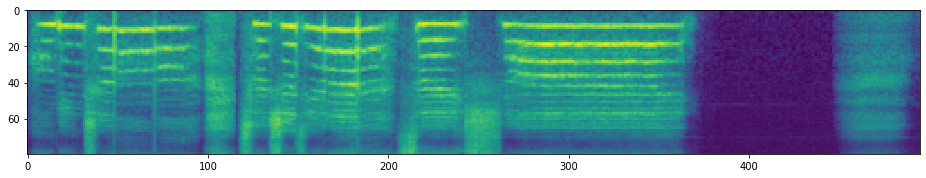

In [82]:
mel_transform = torchaudio.transforms.MelSpectrogram(sample_rate=22050,\
            n_fft=1024,power=1,hop_length=256,win_length=1024, n_mels=80, \
                f_min=0.0, f_max=8000.0, mel_scale="slaney", norm="slaney")
safe_log = lambda x: torch.log(x+2**(-15))
plt.imshow(safe_log(mel_transform(waveform)).detach().numpy()[0], interpolation='none')